# Evaluating GradCAM (base)

## Imports and Setup

In [ ]:
import os
import platform
from pathlib import Path

# for when on NCC to be able to import local packages
os.chdir(os.path.expanduser("~/l3_project"))
Path.cwd()

In [ ]:
import importlib

import helpers
import dataset_processing.eurosat

# to reload local module changes without kernel restart
importlib.reload(helpers.plotting)

In [ ]:
import copy

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import numpy as np
import matplotlib.pyplot as plt
import einops

import torch
import torch.nn as nn

from safetensors.torch import load_model

In [ ]:
print(f'Using PyTorch {torch.__version__} on {platform.system()}')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Found {torch.cuda.get_device_name()} to use as a cuda device.')
elif platform.system() == 'Darwin':
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using {device} as torch device.')

if platform.system() != 'Linux':
    torch.set_num_threads(1)  # significantly speeds up data loading processes with less loading overhead
    # see https://discuss.pytorch.org/t/pytorch-v2-high-cpu-consumption/205990 and https://discuss.pytorch.org/t/cpu-usage-far-too-high-and-training-inefficient/57228
    print('Set number of threads to 1 as using a non-Linux machine.')

In [206]:
np_rng = np.random.default_rng(42)
_ = torch.manual_seed(42)

# EuroSAT (RGB) Dataset

In [ ]:
eurosat_val_ds = dataset_processing.eurosat.get_standard_rgb("val")

num_eurosat_classes = len(eurosat_val_ds.classes)

print(f"There are {len(eurosat_val_ds)} validation samples.")
print("Image dimensions and label:", eurosat_val_ds[0]["image"].size(), eurosat_val_ds[0]["label"])

In [ ]:
val_dataloader = torch.utils.data.DataLoader(
    eurosat_val_ds, batch_size=32, num_workers=4, shuffle=False, drop_last=False
)
validation_iterator = iter(dataset_processing.core.cycle(val_dataloader))

## ResNet 50

### Load Model

In [ ]:
checkpoints_path = Path.cwd() / 'checkpoints'
assert checkpoints_path.exists()

In [ ]:
all_resnet50_saved = list(checkpoints_path.glob('./resnet50/*.st'))
# print(all_resnet50_saved)
latest_resnet50_path = max(all_resnet50_saved, key=os.path.getctime)
latest_resnet50_path

In [ ]:
resnet50 = helpers.models.FineTunedResNet50(num_classes=num_eurosat_classes).to(device)

In [ ]:
print('Missing/Unexpected keys:', load_model(resnet50, latest_resnet50_path))
_ = resnet50.eval()

#### Confirm model accuracy

In [ ]:
check_acc = False
if check_acc:
    _, acc = helpers.ml.validation_step(
        resnet50, nn.CrossEntropyLoss(), validation_iterator, len(val_dataloader)
    )
    assert acc > 0.98
    print("Validation accuracy", acc)

### Select images to explain

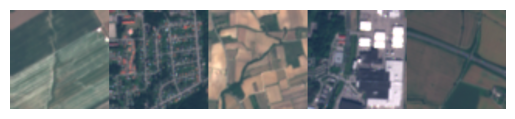

In [207]:
num_imgs_to_sample = 50
idxs_to_explain = np_rng.integers(0, len(eurosat_val_ds), num_imgs_to_sample)
imgs_to_explain = torch.stack([eurosat_val_ds[i]["image"] for i in idxs_to_explain]).to(device)
true_labels = [eurosat_val_ds[i]["label"] for i in idxs_to_explain]
helpers.plotting.show_image(
    einops.rearrange(imgs_to_explain[:5], "(b1 b2) c h w -> c (b1 h) (b2 w)", b2=5))

[tensor(0), tensor(7), tensor(6), tensor(4), tensor(3)]


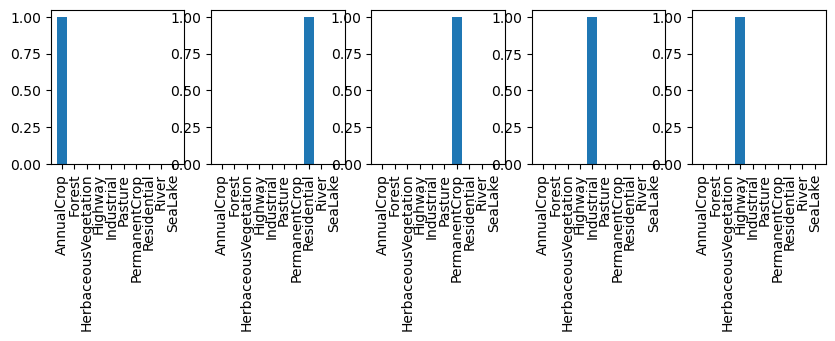

In [208]:
n_visualise = 5
preds = resnet50(imgs_to_explain[:n_visualise])
preds = torch.softmax(preds, dim=-1).cpu().detach().numpy()
_, axs = plt.subplots(1, n_visualise, figsize=(2 * n_visualise, 2))
for i in range(n_visualise):
    ax: plt.Axes = axs[i]
    ax.bar(eurosat_val_ds.classes, preds[i])
    # rotate x ticks for axis
    ax.tick_params(axis='x', rotation=90)
print(true_labels[:n_visualise])

### Set up/Experiment with GradCAM

In [209]:
# target the last layer of the model before avg and fc
gradcam_explainer = GradCAM(resnet50, target_layers=[resnet50.model.layer4[-1]])

In [210]:
cam_output = gradcam_explainer(
    input_tensor=imgs_to_explain,
    aug_smooth=False, eigen_smooth=False,
    targets=None
)

In [211]:
ranked_cam = helpers.evaluate_xai.rank_pixel_importance(cam_output)

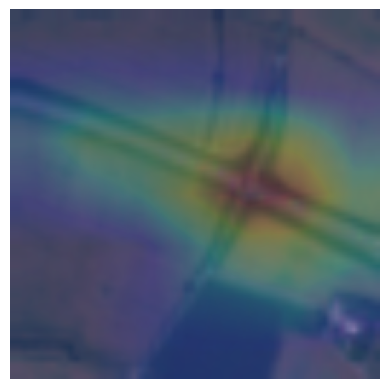

In [221]:
i = 4
true_label_text = eurosat_val_ds.classes[int(true_labels[i])]
# plt.matshow(cam_output[i], cmap="jet")
# plt.show()
# plt.matshow(ranked_cam[i], cmap="jet_r")
# plt.show()
helpers.plotting.show_image(imgs_to_explain[i])
plt.imshow(cam_output[i], cmap="jet", alpha=0.2)
plt.show()

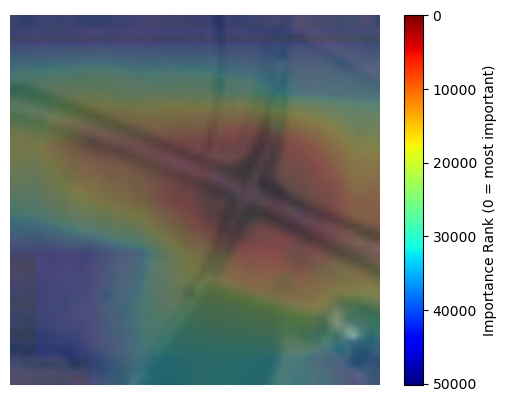

In [213]:
helpers.plotting.visualise_importance(imgs_to_explain[i], ranked_cam[i])

### Model Parameter Randomisation

In [214]:
randomised_model = copy.deepcopy(resnet50).to(device)
helpers.evaluate_xai.reset_child_params(randomised_model)
_ = randomised_model.eval()

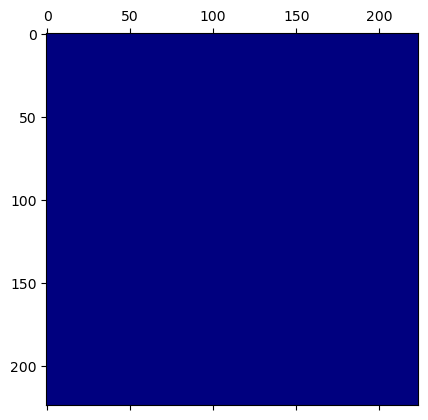

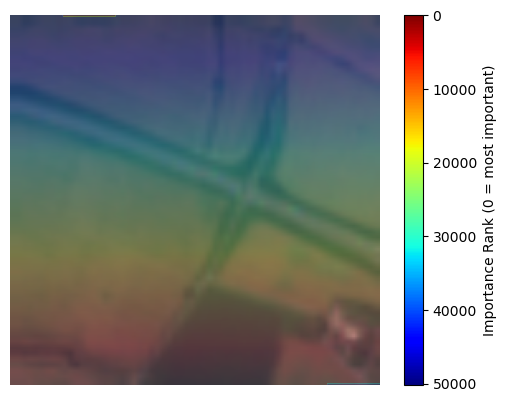

In [215]:
# target the last layer of the model before avg and fc
gradcam_random_explainer = GradCAM(randomised_model, target_layers=[randomised_model.model.layer4[-1]])
cam_random_output = gradcam_random_explainer(
    input_tensor=imgs_to_explain,
    aug_smooth=False, eigen_smooth=False,
    targets=[ClassifierOutputTarget(int(true_labels[i]))]  # since the randomised model isn't going to be accurate
)
ranked_random_cam = helpers.evaluate_xai.rank_pixel_importance(
    cam_random_output)
plt.matshow(cam_random_output[i], cmap="jet")
plt.show()
helpers.plotting.visualise_importance(imgs_to_explain[i], ranked_random_cam[i])

In [226]:
cam_outputs = torch.zeros((len(imgs_to_explain), num_eurosat_classes, *imgs_to_explain.shape[2:], 1))

for c in range(num_eurosat_classes):
    cam_outputs[:, c] = torch.from_numpy(gradcam_explainer(
        input_tensor=imgs_to_explain,
        aug_smooth=False, eigen_smooth=False,
        targets=[ClassifierOutputTarget(c)]  # since the randomised model isn't going to be accurate
    )).unsqueeze(-1)
cam_outputs.size()

torch.Size([50, 10, 224, 224, 1])

In [227]:
random_cam_outputs = torch.zeros((len(imgs_to_explain), num_eurosat_classes, *imgs_to_explain.shape[2:], 1))

for c in range(num_eurosat_classes):
    random_cam_outputs[:, c] = torch.from_numpy(gradcam_random_explainer(
        input_tensor=imgs_to_explain,
        aug_smooth=False, eigen_smooth=False,
        targets=[ClassifierOutputTarget(c)]  # since the randomised model isn't going to be accurate
    )).unsqueeze(-1)
random_cam_outputs.size()

torch.Size([50, 10, 224, 224, 1])

In [228]:
l2_df = helpers.similarity_metrics.make_l2_distance_per_label_df(eurosat_val_ds.classes, cam_outputs.numpy(),
                                                                 random_cam_outputs.numpy(), normalise=True)
l2_df

,L2 distance
Class,
AnnualCrop,0.001314
Forest,0.002380
HerbaceousVegetation,0.002951
Highway,0.003894
Industrial,0.001161
Pasture,0.001749
PermanentCrop,0.003913
Residential,0.002485
River,0.001695


<Axes: title={'center': "L2 distance between randomised and true model's CAM"}, xlabel='class', ylabel='L2 distance'>

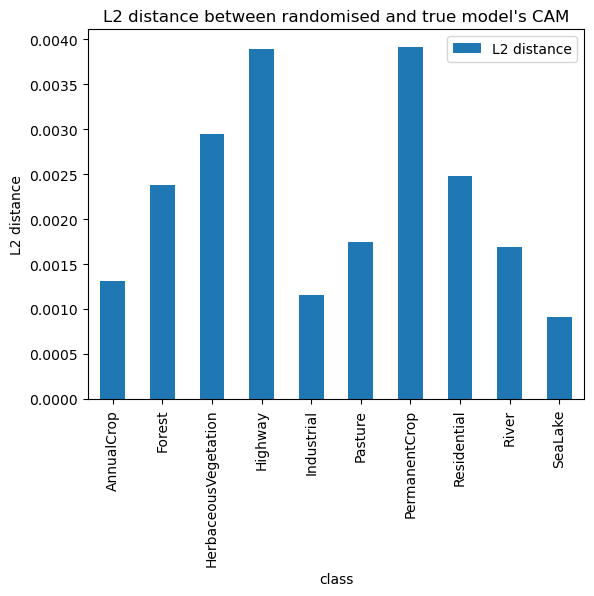

In [229]:
l2_df.plot(kind="bar", xlabel="class", ylabel="L2 distance",
           title="L2 distance between randomised and true model's CAM")

### Incremental Deletion

##### By importance

Incrementally deleting important pixels:   0%|          | 0/31 [00:00<?, ?it/s]

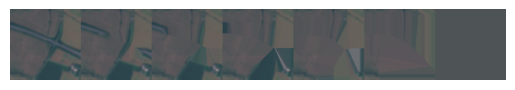

In [230]:
num_del_iterations = 30
iterative_deletions, k_values = helpers.evaluate_xai.incrementally_delete(imgs_to_explain[i].cpu().numpy(),
                                                                          ranked_cam[i],
                                                                          num_del_iterations,
                                                                          "nn")  # Nearest neighbour deletion as in I. Kakogeorgiou and K. Karantzalos
iterative_deletions = np.squeeze(iterative_deletions)  # remove singleton dim (no repeats for specified importance)
helpers.plotting.show_image(einops.rearrange(iterative_deletions[::5], "p c h w -> c h (p w)"))
plt.show()

In [231]:
df = helpers.evaluate_xai.make_preds_df(resnet50, iterative_deletions, columns=eurosat_val_ds.classes)

##### Random

In [232]:
num_rand_trials = 10
random_deletions, k_values = helpers.evaluate_xai.incrementally_delete(imgs_to_explain[i].cpu().numpy(),
                                                                       (16, None, num_rand_trials),
                                                                       num_del_iterations, "nn")

Incrementally deleting important pixels:   0%|          | 0/31 [00:00<?, ?it/s]

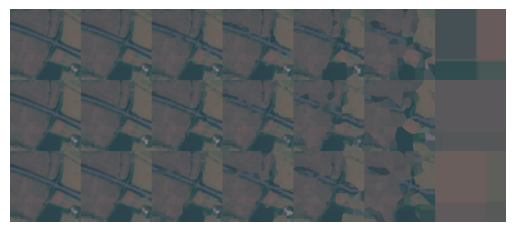

In [234]:
helpers.plotting.show_image(einops.rearrange(random_deletions[::5, :3], "p b c h w -> c (b h) (p w)"))
plt.show()

In [235]:
flatted_random_deletions = random_deletions.reshape(-1, *random_deletions.shape[2:])  # combine iterations and trials

In [236]:
rand_df = helpers.evaluate_xai.make_preds_df(resnet50, flatted_random_deletions, columns=eurosat_val_ds.classes)
# group every num_rand_trials rows (by giving them the same integer index) together and take the average
rand_df = rand_df.groupby(np.arange(len(rand_df)) // num_rand_trials).mean()

<Axes: title={'center': 'Effect of deletions on confidence of correct class prediction'}, xlabel='iterations', ylabel='model confidence'>

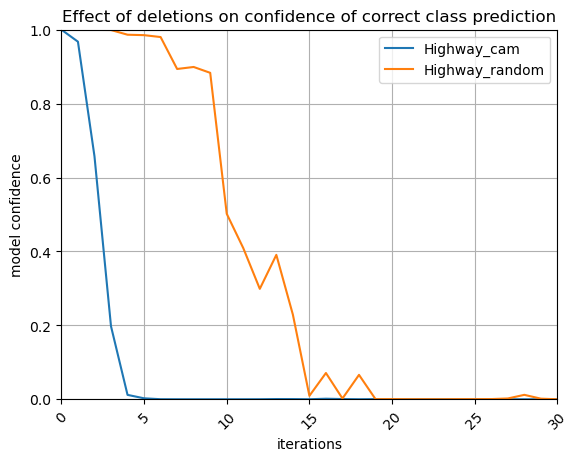

In [237]:
joined_df = df.join(rand_df, lsuffix="_cam", rsuffix="_random")
joined_df.plot(kind="line", xlabel="iterations", rot=45, xlim=(0, num_del_iterations),
               y=[f"{true_label_text}_cam", f"{true_label_text}_random"],
               ylabel="model confidence", ylim=(0, 1),
               grid=True,
               title="Effect of deletions on confidence of correct class prediction")

In [238]:
np.trapz(df[true_label_text].to_numpy()), np.trapz(rand_df[true_label_text].to_numpy())

(2.341683, 11.12206)

{'cam': 2.341683, 'random': 11.12206}

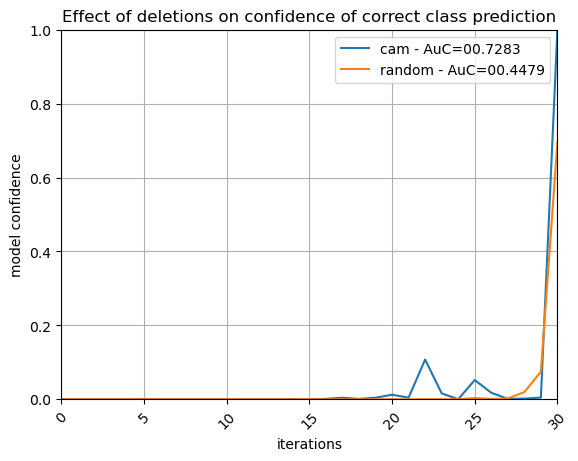

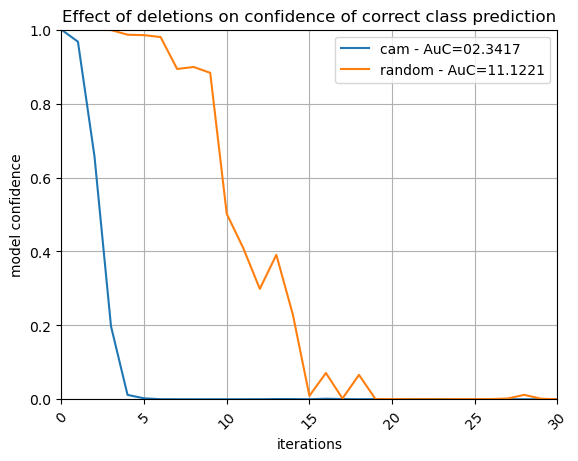

In [239]:
helpers.plotting.make_deletions_plot(df, rand_df,
                                     method_names=["cam", "random"], plot_class="SeaLake",
                                     plt_title="Effect of deletions on confidence of correct class prediction")
helpers.plotting.make_deletions_plot(df, rand_df,
                                     method_names=["cam", "random"], return_aucs=True,
                                     plt_title="Effect of deletions on confidence of correct class prediction")